# Quantifying Spread

Quantification Metrics: 

1. Mean Distance 
    - Take the haversign distance (distance between two points on the surface of a sphere) per each point then find the average 
    - Shows average direction and strength
    - Lacks spread quantifcation
2. Intersection Over Union
    - Create a solid outline by connecting all outermost dots
    - Comparitive metric between two simulations
    - OR spread could be quantified by the area of the shape
    - When the IOU does not change significantly between simulations, they have stabalized in spread? 
3. Coeffient of Variation - assuming we can get multiple particles per grid cell or total per cell
    - Create one metric per cell to evaluate the stability of the model
        - Treat each cell with a non-zero value as a particle considered in the variation
        - do this for each cell (if you can get the particles for each cell) - results in a COE per each cell - look at the stability of cells per each simulation 

In [1]:
#Basics: 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from math import radians, cos, sin, asin, sqrt
import glob

#Geo
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 
from shapely.geometry import Point, Polygon

import alphashape
from descartes import PolygonPatch

In [2]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

def geography_point_IOU(geo_dataframe,alpha_level):
    """Creates a shapefile outline for the given geodataframe using a convex hull operation. 

    ===
    Inputs:
    1. geo_dataframe - a geopandas dataframe with STILT ouputs converted into shapefile points (lat, lon)
    2. alpha_level - a value which dictates how strictly the convex hull operation attempts to keep all points within the shape (dependent on coordinate system!)

    Outputs:
    1. sq_km_area = the sq km area of the polygon. Note this value is projectionally dependent. 
    2. IOU_gdf = a dataframe containg the polygon adaptation of the point files
    ===
    """

    #Weird Initialization necessary 
    IOU_gdf = {'Lat':[00.00,],'Lon':[00.00]}
    IOU_gdf = pd.DataFrame(IOU_gdf)

    #Convert to a geodataframe
    IOU_gdf = gpd.GeoDataFrame(IOU_gdf, geometry=gpd.points_from_xy(x=IOU_gdf['Lon'], y=IOU_gdf['Lat']))
    IOU_gdf = IOU_gdf.set_crs(epsg=3857)

    #Create a shape using convex hull (there are better ways to do this which are more exact http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/)
    #This is an ok approximation for now 
    IOU_gdf['geometry'] = alphashape.alphashape(geo_dataframe['geometry'],alpha_level)

    sq_km_area = IOU_gdf['geometry'].iloc[0].area / 10**6

    return sq_km_area,IOU_gdf

def mean_distance(stilt_simulation_shapefile, origin_source_lat, origin_source_lon):
    """Calculates the mean distance between a dataframe and associated origin point.

    ===
    Inputs:
    1. stilt_simulation_shapefile - a geopandas dataframe with STILT ouputs converted into shapefile points (lat, lon)
    2. origin_source_lat - the latitude point of reference
    3. origin_source_lon - the longitude point of reference

    Outputs:
    1. returns the average distance between the origin lat/lon and each of the satellite points. 
    ===
    """

    stilt_sim = stilt_simulation_shapefile

    #Calculate the distance: 
    stilt_sim['tri_origin_release_lon'] = origin_source_lon
    stilt_sim['tri_origin_release_lat'] = origin_source_lat
    stilt_sim['stilt_sim_distance'] = haversine(stilt_sim['lat'], stilt_sim['lon'], stilt_sim['tri_origin_release_lat'], stilt_sim['tri_origin_release_lon'])

    #Verify the distances  by plot
    #stilt_sim.plot(column = 'stilt_sim_distance')
    #plt.close()

    return np.mean(stilt_sim['stilt_sim_distance'])

# Putting it Together

Tack all information into a dataframe which keeps a column based upon the original dataname.

This should include some way to connect the original TRI release information fromt he simulation. 

So it seems like the r files are identical and there these random patches which show up in the netcdf. It is not the post processing but the actual modeling. Need to figure out why that is happening. It is not linked to the heights, it appears the ones that are working are fairly random. 

So i need to send Ben the original run file, data used to run and output and see if he knows why that is happening.

For now, I am going to use a more "ideal" plot to try and finish the pipeline for output metrics

In [80]:
parameter_tuning_df = pd.DataFrame(columns = ['name','data_path','TRI_release_lat','TRI_release_lon','Mean_average_distance_from_origin','Shape_area','shape_geometry','Coefficient_of_variation','id'])

import glob
from scipy.stats import variation

data = []
data_folder_name ='092120_tuning_run_2/'
run_df = pd.read_csv('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/unique_TRI_location_height_year_stilt_RUN.csv')

for files in glob.glob('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/stilt_output/' + data_folder_name + '*'):

    #extract the simulation_name
    name = files.split(data_folder_name)[1]

    #we can rely on the lat and lon being reliable as the name is coming from STILT
    lat = float(name.split('_')[2])
    lon = float(name.split('_')[1])

    #Load the file
    stilt_processed_gdf = gpd.read_file(files)

    #Filter down the files
    stilt_processed_gdf = stilt_processed_gdf[stilt_processed_gdf.foot>0.0001]

    #Calculate the mean distance
    mean_dist = mean_distance(stilt_processed_gdf, lat, lon)
    
    #Calculate the area and shape of the plume
    area, area_polygon = geography_point_IOU(stilt_processed_gdf,0.00001)

    #Coeff of Variation
    COV = variation(stilt_processed_gdf['foot'],axis =0)
    
    #Gather and add the merge ID

    #As long as we treat the data outputs of stilt as immutable - this should work fine
    YEAR = int(name.split('_')[0][0:4])
    longi = float(name.split('_')[1])
    lati = float(name.split('_')[2])
    zagl = float(name.split('_')[3])

    temp_find = run_df[(run_df.YEAR == YEAR) & (run_df.zagl == zagl) & (run_df.long.round(6) == longi) & (run_df.lati.round(6) == lati)]
    temp_id = temp_find['id'].values[0]

    #Plot the stuff
    #fig,ax = plt.subplots(1,1,figsize=(15,15))
    #area_polygon.plot(ax = ax,color='b',alpha=0.2)
    #stilt_processed_gdf.plot(ax = ax,cmap = 'YlOrRd', markersize=10,column = 'foot')
    #ctx.add_basemap(ax)
    #ax.axes.xaxis.set_visible(False)
    #ax.axes.yaxis.set_visible(False)
    #ax.set_title('{0}'.format(name))
    #plt.savefig('/home/boogie2/Hanson_Lab/TRI_STILT/figures/{}.png'.format(name))
    #plt.close()
    
    data.append([name,files,lat,lon,mean_dist,area,area_polygon['geometry'].iloc[0],COV,temp_id])
parameter_tuning_df = pd.DataFrame(data, columns = ['name','data_path','TRI_release_lat','TRI_release_lon','Mean_average_distance_from_origin','Shape_area','shape_geometry','Coefficient_of_variation','id'])

In [81]:
#Create a figure to showcase everything
parameter_tuning_df.head()

,name,data_path,TRI_release_lat,TRI_release_lon,Mean_average_distance_from_origin,Shape_area,shape_geometry,Coefficient_of_variation,id
0,199003010000_-112.01698_41.09394_16.6_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...,41.093940,-112.016980,65.990959,8894.641675,POLYGON ((-12564074.32838282 4990977.665177196...,1.389718,40
1,199009300000_-112.186278_40.726834_16.6_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...,40.726834,-112.186278,44.777464,8282.153108,POLYGON ((-12500622.21863066 4849244.838515353...,4.568876,26
2,199310090000_-111.9045_40.7523_9.1_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...,40.752300,-111.904500,7.494512,497.332238,POLYGON ((-12441622.88851022 4967457.790419347...,1.590259,274
3,199506160000_-111.921443_40.838386_0_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...,40.838386,-111.921443,51.085855,1249.376459,"POLYGON ((-12459434.00703715 4988034.58002491,...",1.063805,477
4,199408160000_-110.12491_40.388555_10.7_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...,40.388555,-110.124910,20.727060,1137.573841,POLYGON ((-12222323.49164747 4895777.192686847...,1.352735,390


In [294]:
import glob


data = []
data_folder_name ='092120_tuning_run_2/'
run_df = pd.read_csv('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/unique_TRI_location_height_year_stilt_RUN.csv')
id_mappings_df = pd.read_csv('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/unique_TRI_location_height_year_id_mappings.csv')

for files in glob.glob('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/stilt_output/' + data_folder_name + '*'):

    #extract the simulation_name
    name = files.split(data_folder_name)[1]

    #load the data
    stilt_processed_gdf = gpd.read_file(files)

    #Filter down the files
    stilt_processed_gdf = stilt_processed_gdf[stilt_processed_gdf.foot>0]

    #As long as we treat the data outputs of stilt as immutable - this should work fine
    YEAR = int(name.split('_')[0][0:4])
    longi = float(name.split('_')[1])
    lati = float(name.split('_')[2])
    zagl = float(name.split('_')[3])

    temp_find = run_df[(run_df.YEAR == YEAR) & (run_df.zagl == zagl) & (run_df.long.round(6) == longi) & (run_df.lati.round(6) == lati)]
    temp_id = temp_find['id'].values[0]

    data.append([name,files,temp_id])
stilt_sim_df = pd.DataFrame(data, columns = ['STILT_SIMULATION_name','STILT_simulation__path','id'])

#Merge the original chemical and release amount information
stilt_sim_df = id_mappings_df.merge(stilt_sim_df)

In [ ]:
#Need to still add the year month day to the index

In [305]:
stilt_sim_df

,lati,long,zagl,Chemical,Release (lbs/year),YEAR,id,STILT_SIMULATION_name,STILT_simulation__path
0,40.674130,-111.923280,9.8,ETHYLENE OXIDE,3966.0,1990,5,199011170000_-111.92328_40.67413_9.8_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
1,40.674130,-111.923280,9.8,DI(2-ETHYLHEXYL) PHTHALATE,2993.0,1990,5,199011170000_-111.92328_40.67413_9.8_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
2,40.728170,-111.888240,0.0,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",250.0,1990,15,199008010000_-111.88824_40.72817_0_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
3,40.726834,-112.186278,16.6,"SULFURIC ACID (1994 AND AFTER ACID AEROSOLS"" O...",5.0,1990,26,199009300000_-112.186278_40.726834_16.6_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
4,41.093940,-112.016980,16.6,"1,4-DIOXANE",2400.0,1990,40,199003010000_-112.01698_41.09394_16.6_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
5,40.788900,-111.904410,30.5,ETHYLBENZENE,700.0,1991,105,199107160000_-111.90441_40.7889_30.5_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
6,40.788900,-111.904410,30.5,BENZENE,4400.0,1991,105,199107160000_-111.90441_40.7889_30.5_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
7,40.788900,-111.904410,30.5,NAPHTHALENE,50.0,1991,105,199107160000_-111.90441_40.7889_30.5_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
8,41.882500,-112.196400,0.0,LEAD,3973.0,1992,171,199211010000_-112.1964_41.8825_0_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
9,41.203450,-111.982390,2.1,METHYL ISOBUTYL KETONE,7735.0,1992,174,199212080000_-111.98239_41.20345_2.1_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...


<AxesSubplot:>

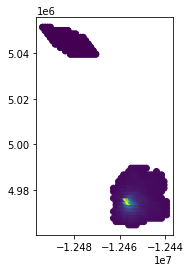

In [309]:
test = stilt_sim_gdf[(stilt_sim_gdf['Chemical']=='METHYL ISOBUTYL KETONE')&(stilt_sim_gdf['YEAR']==1993)]
test.plot(column = 'release')

In [ ]:
METHYL ISOBUTYL KETONE

In [298]:
#Put it together:
data = []

for rows in range(stilt_sim_df.shape[0]):
    stilt_sim_gdf = gpd.read_file(stilt_sim_df['STILT_simulation__path'].iloc[rows])
    stilt_sim_gdf['release'] = stilt_sim_gdf.foot * stilt_sim_df['Release (lbs/year)'].iloc[rows]/365 #not accounting for leap year yet
    stilt_sim_gdf['id'] = stilt_sim_df['id'].iloc[rows]
    data.append(stilt_sim_gdf)

#Concatenate into a single dataframe
stilt_sim_gdf = pd.concat(data)

stilt_sim_gdf = stilt_sim_gdf.merge(stilt_sim_df).rename(columns = {'lati':'TRI_source_lati','long':'TRI_source_long'})
stilt_sim_gdf

,lat,lon,foot,geometry,release,id,TRI_source_lati,TRI_source_long,zagl,Chemical,Release (lbs/year),YEAR,STILT_SIMULATION_name,STILT_simulation__path
0,40.665,-111.925,0.000257,POINT (-12459434.007 4963054.108),0.002793,5,40.67413,-111.92328,9.8,ETHYLENE OXIDE,3966.0,1990,199011170000_-111.92328_40.67413_9.8_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
1,40.665,-111.925,0.000257,POINT (-12459434.007 4963054.108),0.002793,5,40.67413,-111.92328,9.8,DI(2-ETHYLHEXYL) PHTHALATE,2993.0,1990,199011170000_-111.92328_40.67413_9.8_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
2,40.675,-112.005,0.000133,POINT (-12468339.566 4964521.782),0.001444,5,40.67413,-111.92328,9.8,ETHYLENE OXIDE,3966.0,1990,199011170000_-111.92328_40.67413_9.8_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
3,40.675,-112.005,0.000133,POINT (-12468339.566 4964521.782),0.001444,5,40.67413,-111.92328,9.8,DI(2-ETHYLHEXYL) PHTHALATE,2993.0,1990,199011170000_-111.92328_40.67413_9.8_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
4,40.675,-111.995,0.000123,POINT (-12467226.371 4964521.782),0.001336,5,40.67413,-111.92328,9.8,ETHYLENE OXIDE,3966.0,1990,199011170000_-111.92328_40.67413_9.8_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142176,40.695,-111.845,0.000204,POINT (-12450528.448 4967457.790),0.001615,752,40.69354,-111.91120,9.4,STYRENE,2892.0,1999,199909080000_-111.9112_40.69354_9.4_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
142177,40.695,-111.835,0.000162,POINT (-12449415.253 4967457.790),0.001282,752,40.69354,-111.91120,9.4,STYRENE,2892.0,1999,199909080000_-111.9112_40.69354_9.4_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
142178,40.695,-111.825,0.000101,POINT (-12448302.058 4967457.790),0.000797,752,40.69354,-111.91120,9.4,STYRENE,2892.0,1999,199909080000_-111.9112_40.69354_9.4_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...
142179,40.695,-111.805,0.000105,POINT (-12446075.668 4967457.790),0.000835,752,40.69354,-111.91120,9.4,STYRENE,2892.0,1999,199909080000_-111.9112_40.69354_9.4_foot,/home/boogie2/Hanson_Lab/TRI_STILT/data/proces...


# Starting Runs with Parameter Changes

Using a subsample of data coming from receptor_creator.r file in stilt>code to produce a sample of 20 random points over the years.

first run paramters: 

particles: 200 
<br>
smoothing: idk



In [ ]:
#Convert everything to being compatible on CHPC